In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header = None)
X, y = df.iloc[:, 1:].values, df.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify = y, random_state = 0)

In [3]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

In [4]:
np.set_printoptions(precision=4)
mean_vecs = []
for label in range(1 , 4):
    mean_vecs.append(np.mean(X_train_std[y_train == label] , axis = 0))

In [5]:
d = 13
S_W = np.zeros((d , d))
for label , mv in zip(range(1 , 4) , mean_vecs):
    class_scatter = np.zeros((d , d))
    for row in X_train_std[y_train == label]:
        row , mv = row.reshape(d , 1) , mv.reshape(d , 1)
        class_scatter += (row-mv).dot((row-mv).T)
    S_W += class_scatter

In [7]:
#violation of normal distrubution assumption
print(np.bincount(y_train)[1:])

[41 50 33]


In [8]:
#defining with covariance matrix
d = 13 #number of features
S_W = np.zeros((d , d))
for label , mv in zip(range(1 , 4) , mean_vecs):
    class_scatter = np.cov(X_train_std[y_train == label].T)
    S_W += class_scatter

In [9]:
mean_overall = np.mean(X_train_std, axis=0)
d = 13#number of features
S_B = np.zeros((d, d))
for i, mean_vec in enumerate(mean_vecs):
    n = X_train[y_train == i + 1, :].shape[0]
    mean_vec = mean_vec.reshape(d, 1) 
    mean_overall = mean_overall.reshape(d, 1)
    S_B += n * (mean_vec - mean_overall).dot((mean_vec - mean_overall).T)
print('Between-class scatter matrix: %sx%s' % (S_B.shape[0], S_B.shape[1]))

Between-class scatter matrix: 13x13


In [10]:
#solving generalize eigen values
eigen_vals , eigen_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

In [11]:
#sorting eigen pairs in descending order 
eigen_pairs = [(np.abs(eigen_vals)[i] , eigen_vecs[:,i] ) for i in range(len(eigen_vals))]
eigen_pairs = sorted(eigen_pairs , key = lambda k : k[0] ,reverse = True)

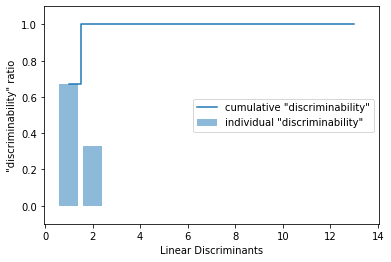

In [12]:
#plotting class discriminatory information
import matplotlib.pyplot as plt
tot = sum(eigen_vals.real)
discr = [(i / tot) for i in sorted(eigen_vals.real, reverse=True)]
cum_discr = np.cumsum(discr)
plt.bar(range(1, 14), discr, alpha=0.5, align='center', label='individual "discriminability"')
plt.step(range(1, 14), cum_discr, where='mid', label='cumulative "discriminability"')
plt.ylabel('"discriminability" ratio')
plt.xlabel('Linear Discriminants')
plt.ylim([-0.1, 1.1])
plt.legend(loc='best')
plt.show() 

In [13]:
#creation of transformation matrix
w = np.hstack((eigen_pairs[0][1][: , np.newaxis].real , 
               eigen_pairs[1][1][: , np.newaxis].real))

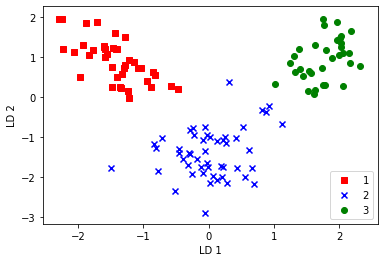

In [14]:
#projection of sample into new feature subspace
X_train_lda = X_train_std.dot(w)
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']
for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_lda[y_train==l, 0],
                X_train_lda[y_train==l, 1] * (-1), 
                c=c, label=l, marker=m)
plt.xlabel('LD 1') 
plt.ylabel('LD 2')
plt.legend(loc='lower right')
plt.show() 

In [15]:
#LDA via scikit learn

In [16]:
from matplotlib.colors import ListedColormap 
def plot_decision_regions(X, y, classifier, resolution=0.02):    
    # setup marker generator and color map    
    markers = ('s', 'x', 'o', '^', 'v')    
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')    
    cmap = ListedColormap(colors[:len(np.unique(y))])    
    # plot the decision surface    
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1    
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1    
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution), np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)    
    Z = Z.reshape(xx1.shape)    
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)    
    plt.xlim(xx1.min(), xx1.max())    
    plt.ylim(xx2.min(), xx2.max())    
    # plot class samples    
    for idx, cl in enumerate(np.unique(y)):        
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],                
                    alpha=0.6,                     
                    c=cmap(idx),                    
                    edgecolor='black',                    
                    marker=markers[idx],                     
                    label=cl) 

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


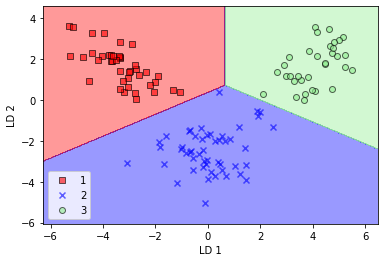

In [17]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression
lda = LDA(n_components = 2)
X_train_lda = lda.fit_transform(X_train_std , y_train)
lr = LogisticRegression()
lr.fit(X_train_lda , y_train)
plot_decision_regions(X_train_lda , y_train , classifier = lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


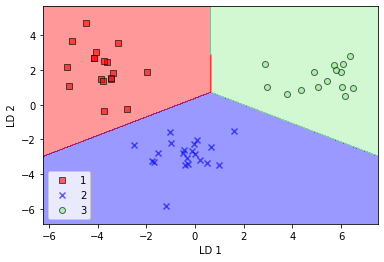

In [18]:
#for test dataset
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression
lda = LDA(n_components = 2)
X_test_lda = lda.fit_transform(X_test_std , y_test)
plot_decision_regions(X_test_lda, y_test, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.show() 